# SQL Project: Electric Vehicle Market Penetration & Growth Trends in India

## Objective

The objective of this project is to conduct a comprehensive analysis of the Indian electric vehicle (EV) market using SQL. AtliQ Motors, a leading EV manufacturer in North America, is exploring opportunities to expand into India, where its market share is currently less than 2%.

As a data analyst, the goal is to:

- Understand EV adoption trends across Indian states and brands

- Identify top-performing manufacturers and high-penetration regions

- Analyze growth patterns using metrics like EV penetration rate and CAGR

- Derive actionable business insights to support AtliQ’s India launch strategy

The project involves writing SQL queries on a PostgreSQL database, performing time-series and comparative analysis, and visualizing insights using Python (pandas, matplotlib/seaborn).

### About Dataset

The project uses three CSV files containing EV sales data across India, loaded into a PostgreSQL database for analysis:

- dim_date: Time dimension with date, fiscal_year, and quarter – used for time-based grouping.

- electric_vehicle_sales_by_state: Monthly EV and total vehicle sales by state and vehicle_category – used to analyze regional trends and EV penetration.

- electric_vehicle_sales_by_makers: EV sales by maker, date, and vehicle_category – used to assess brand performance and market share.

##  Step 2 – Data Profiling & Quality Checks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import calendar
import warnings
warnings.filterwarnings("ignore", message="pandas only supports SQLAlchemy")

In [2]:
 # Connect to your PostgreSQL database
conn = psycopg2.connect(
        dbname="atliq_ev",         
        user="postgres",       
        password= "12345",   
        host="localhost",         
        port="5432"                 
    )

    # Create a cursor object
cur = conn.cursor()
print("✅ Connection successful!")




✅ Connection successful!


#### Check 1: NULL Values

In [3]:
# Nulls in state-level data
pd.read_sql("""
SELECT 
  COUNT(*) FILTER (WHERE date IS NULL) AS null_date,
  COUNT(*) FILTER (WHERE state IS NULL) AS null_state,
  COUNT(*) FILTER (WHERE vehicle_category IS NULL) AS null_category,
  COUNT(*) FILTER (WHERE electric_vehicles_sold IS NULL) AS null_ev,
  COUNT(*) FILTER (WHERE total_vehicles_sold IS NULL) AS null_total
FROM electric_vehicle_sales_by_state;
""", conn)


,null_date,null_state,null_category,null_ev,null_total
0,0,0,0,0,0


In [4]:
# Nulls in maker-level data
pd.read_sql("""
SELECT 
  COUNT(*) FILTER (WHERE date IS NULL) AS null_date,
  COUNT(*) FILTER (WHERE maker IS NULL) AS null_maker,
  COUNT(*) FILTER (WHERE vehicle_category IS NULL) AS null_category,
  COUNT(*) FILTER (WHERE electric_vehicles_sold IS NULL) AS null_ev
FROM electric_vehicle_sales_by_makers;
""", conn)


,null_date,null_maker,null_category,null_ev
0,0,0,0,0


####  Check 2: Duplicate Records

In [5]:
# Duplicates in state table
pd.read_sql("""
SELECT date, state, vehicle_category, COUNT(*)
FROM electric_vehicle_sales_by_state
GROUP BY date, state, vehicle_category
HAVING COUNT(*) > 1;
""", conn)


,date,state,vehicle_category,count


In [6]:
# Duplicates in maker table
pd.read_sql("""
SELECT date, vehicle_category, maker, COUNT(*)
FROM electric_vehicle_sales_by_makers
GROUP BY date, vehicle_category, maker
HAVING COUNT(*) > 1;
""", conn)


,date,vehicle_category,maker,count


#### Check 3: Valid Categories and Names

In [7]:
# Unique vehicle categories
pd.read_sql("SELECT DISTINCT vehicle_category FROM electric_vehicle_sales_by_state", conn)


,vehicle_category
0,2-Wheelers
1,4-Wheelers


In [8]:
# Unique states
pd.read_sql("SELECT DISTINCT state FROM electric_vehicle_sales_by_state ORDER BY state", conn)


,state
0,Andaman & Nicobar
1,Andaman & Nicobar Island
2,Andhra Pradesh
3,Arunachal Pradesh
4,Assam
5,Bihar
6,Chandigarh
7,Chhattisgarh
8,Delhi
9,DNH and DD


In [9]:
# Unique makers
pd.read_sql("SELECT DISTINCT maker FROM electric_vehicle_sales_by_makers ORDER BY maker", conn)


,maker
0,AMPERE
1,ATHER
2,BAJAJ
3,BATTRE ELECTRIC
4,BEING
5,BGAUSS
6,BMW India
7,BYD India
8,HERO ELECTRIC
9,Hyundai Motor


####  Check 4: Outliers (Negative Values)

In [10]:
# Negative sales
pd.read_sql("""
SELECT * FROM electric_vehicle_sales_by_state
WHERE electric_vehicles_sold < 0 OR total_vehicles_sold < 0
""", conn)


,date,state,vehicle_category,electric_vehicles_sold,total_vehicles_sold


## 📝 Data Profiling Summary

- No NULL values found in critical columns ✅  
- No duplicate rows detected in either fact table ✅  
- Vehicle categories are consistent: only `2-Wheeler` and `4-Wheeler` ✅  
- No negative sales figures found ✅  
- Data is clean and ready for analysis 🎯  


##  Step 3 – Core SQL Analysis

###  1)List the top 3 makers for the fiscal years 2023 and 2024 in terms of the number of 2-wheelers sold. 

In [11]:
query = """
SELECT 
    m.maker,
    SUM(m.electric_vehicles_sold) AS total_ev_sold
FROM 
    electric_vehicle_sales_by_makers m
JOIN 
    dim_date d ON m.date = d.date
WHERE 
    m.vehicle_category = '2-Wheelers'
    AND d.fiscal_year IN ('2023', '2024')
GROUP BY 
    m.maker
ORDER BY 
    total_ev_sold DESC
LIMIT 3;
"""

df = pd.read_sql(query, conn)
df


,maker,total_ev_sold
0,OLA ELECTRIC,475072
1,TVS,262836
2,ATHER,184473


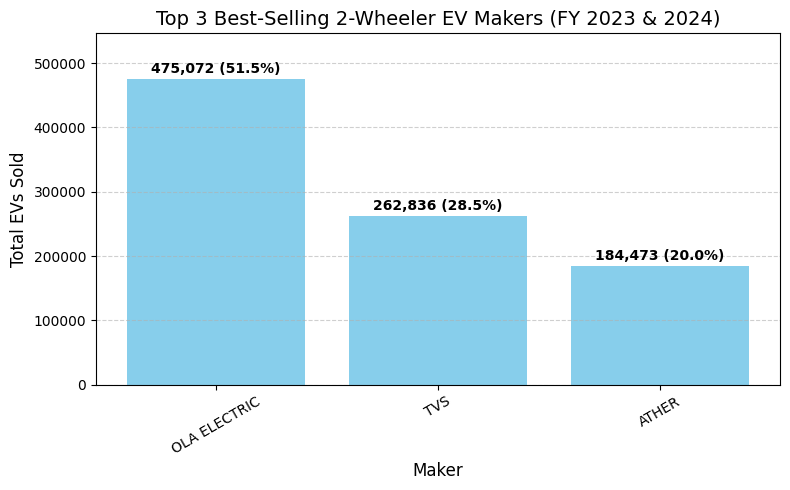

In [12]:
total = df['total_ev_sold'].sum()

plt.figure(figsize=(8, 5))
bars = plt.bar(df['maker'], df['total_ev_sold'], color='skyblue')
plt.title('Top 3 Best-Selling 2-Wheeler EV Makers (FY 2023 & 2024)', fontsize=14)
plt.xlabel('Maker', fontsize=12)
plt.ylabel('Total EVs Sold', fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Extend y-axis limit to fix label cutoff
plt.ylim(0, df['total_ev_sold'].max() * 1.15)

# Add value and percentage on bars
for i, bar in enumerate(bars):
    value = df['total_ev_sold'][i]
    percentage = (value / total) * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        value + total * 0.01,  # slightly above the bar
        f"{value:,} ({percentage:.1f}%)",
        ha='center',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


- ola electric,TVs,Ather are top 3 best selling 2-wheelers
- ola dominate with over half of total sales

###  List the bottom 3 makers for the fiscal years 2023 and 2024 in terms of the number of 2-wheelers sold.

In [13]:
query = """
select
   m.maker,
   sum(m.electric_vehicles_sold) as total_ev_sold
from 
  electric_vehicle_sales_by_makers m
join
   dim_date d on m.date = d.date
where 
   m.vehicle_category = '2-Wheelers'
   and d.fiscal_year in ('2023','2024')
group by
   m.maker
order by
   total_ev_sold Asc
limit 3;
"""

df = pd.read_sql(query,conn)
df

,maker,total_ev_sold
0,BATTRE ELECTRIC,4841
1,JITENDRA,8563
2,KINETIC GREEN,9585


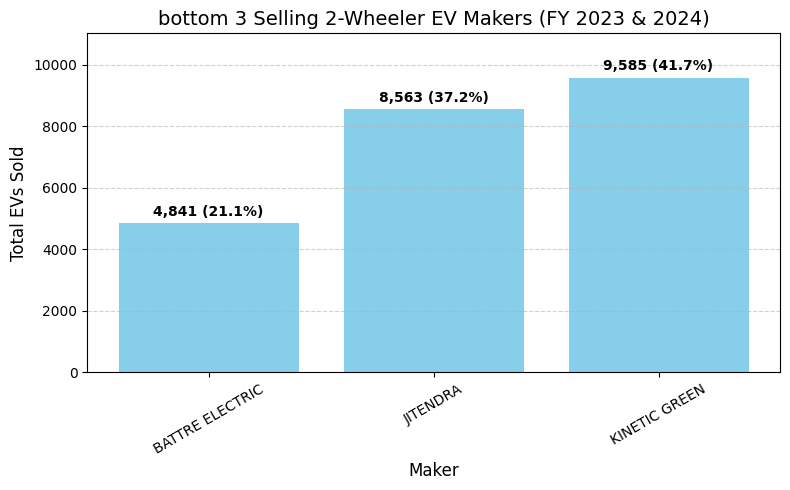

In [14]:
total = df['total_ev_sold'].sum()

plt.figure(figsize=(8, 5))
bars = plt.bar(df['maker'], df['total_ev_sold'], color='skyblue')
plt.title('bottom 3 Selling 2-Wheeler EV Makers (FY 2023 & 2024)', fontsize=14)
plt.xlabel('Maker', fontsize=12)
plt.ylabel('Total EVs Sold', fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Extend y-axis limit to fix label cutoff
plt.ylim(0, df['total_ev_sold'].max() * 1.15)

# Add value and percentage on bars
for i, bar in enumerate(bars):
    value = df['total_ev_sold'][i]
    percentage = (value / total) * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        value + total * 0.01,  # slightly above the bar
        f"{value:,} ({percentage:.1f}%)",
        ha='center',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


- battre electric,jitendra,kinetic green are bottom 3 selling 2-wheelers
- battre electric with just 4841 unit clearly falling behind

## List the top 3 makers for the fiscal years 2023 and 2024 in terms of the number of 4-wheelers sold.

In [15]:
query = """
SELECT 
    m.maker,
    SUM(m.electric_vehicles_sold) AS total_ev_sold
FROM 
    electric_vehicle_sales_by_makers m
JOIN 
    dim_date d ON m.date = d.date
WHERE 
    m.vehicle_category = '4-Wheelers'
    AND d.fiscal_year IN ('2023', '2024')
GROUP BY 
    m.maker
ORDER BY 
    total_ev_sold DESC
LIMIT 3;
"""

df = pd.read_sql(query, conn)
df

,maker,total_ev_sold
0,Tata Motors,76227
1,Mahindra & Mahindra,37151
2,MG Motor,12106


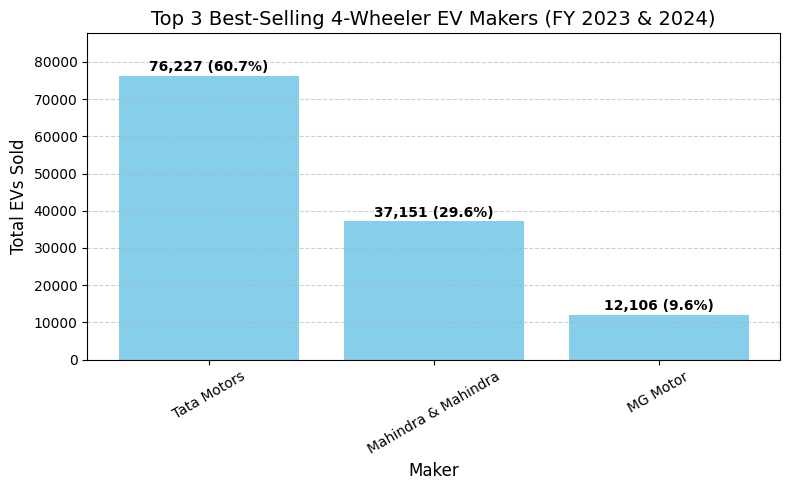

In [16]:
total = df['total_ev_sold'].sum()

plt.figure(figsize=(8, 5))
bars = plt.bar(df['maker'], df['total_ev_sold'], color='skyblue')
plt.title('Top 3 Best-Selling 4-Wheeler EV Makers (FY 2023 & 2024)', fontsize=14)
plt.xlabel('Maker', fontsize=12)
plt.ylabel('Total EVs Sold', fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Extend y-axis limit to fix label cutoff
plt.ylim(0, df['total_ev_sold'].max() * 1.15)

# Add value and percentage on bars
for i, bar in enumerate(bars):
    value = df['total_ev_sold'][i]
    percentage = (value / total) * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        value + total * 0.01,  # slightly above the bar
        f"{value:,} ({percentage:.1f}%)",
        ha='center',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

1. Tata Motors Dominates the Market
With 76,227 EVs sold, Tata Motors holds a massive 60.7% market share.

This makes it the clear market leader in the 4-wheeler EV segment for FY 2023 & 2024.

2. Mahindra & Mahindra Is a Distant Second
Sold 37,151 EVs, which is 29.6% of the total.

While far behind Tata, it has a strong presence and is a key player in the segment.

3. MG Motor Has a Smaller Share
Sold 12,106 EVs, making up only 9.6% of the market.

This indicates limited penetration compared to the top two but still in the top 3.

## List the bottom 3 makers for the fiscal years 2023 and 2024 in terms of the number of 4-wheelers sold.


In [17]:
query = """
select
   m.maker,
   sum(m.electric_vehicles_sold) as total_ev_sold
from 
  electric_vehicle_sales_by_makers m
join
   dim_date d on m.date = d.date
where 
   m.vehicle_category = '4-Wheelers'
   and d.fiscal_year in ('2023','2024')
group by
   m.maker
order by
   total_ev_sold Asc
limit 3;
"""

df = pd.read_sql(query,conn)
df

,maker,total_ev_sold
0,Mercedes -Benz AG,362
1,KIA Motors,557
2,Volvo Auto India,564


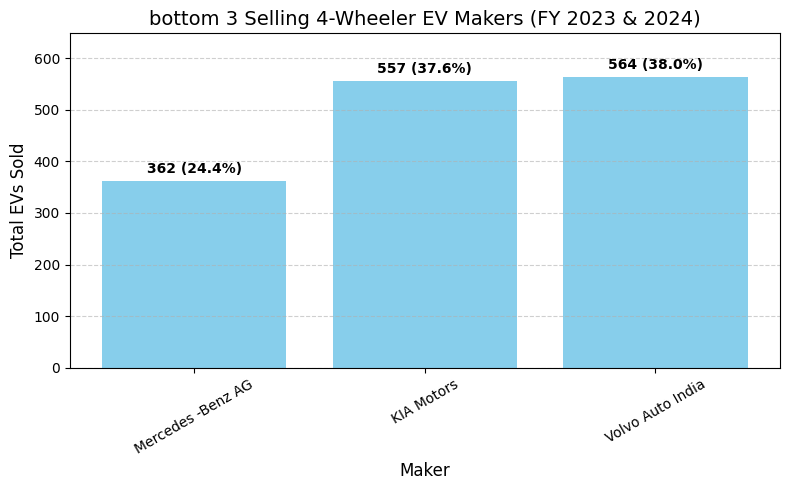

In [18]:
total = df['total_ev_sold'].sum()

plt.figure(figsize=(8, 5))
bars = plt.bar(df['maker'], df['total_ev_sold'], color='skyblue')
plt.title('bottom 3 Selling 4-Wheeler EV Makers (FY 2023 & 2024)', fontsize=14)
plt.xlabel('Maker', fontsize=12)
plt.ylabel('Total EVs Sold', fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Extend y-axis limit to fix label cutoff
plt.ylim(0, df['total_ev_sold'].max() * 1.15)

# Add value and percentage on bars
for i, bar in enumerate(bars):
    value = df['total_ev_sold'][i]
    percentage = (value / total) * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        value + total * 0.01,  # slightly above the bar
        f"{value:,} ({percentage:.1f}%)",
        ha='center',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

Mercedes-Benz AG had the lowest 4-wheeler EV sales with just 362 units (24.4%) in FY 2023 & 2024, followed by KIA Motors (557 units, 37.6%) and Volvo Auto India (564 units, 38.0%), indicating minimal market presence compared to leading players.

###  Identify the top 5 states with the highest penetration rate in 2-wheeler EV sales in FY 2024.

In [19]:
query = """
SELECT
    s.state,
    s.vehicle_category AS two_wheelers,
    SUM(s.electric_vehicles_sold)::float / NULLIF(SUM(s.total_vehicles_sold), 0) * 100 AS penetration_rate
FROM 
    electric_vehicle_sales_by_state s
JOIN
    dim_date d ON s.date = d.date
WHERE
    d.fiscal_year = '2024'
    AND s.vehicle_category = '2-Wheelers'
GROUP BY 
    s.state, s.vehicle_category
ORDER BY 
    penetration_rate DESC
LIMIT 5;
"""

df = pd.read_sql(query, conn)
df


,state,two_wheelers,penetration_rate
0,Goa,2-Wheelers,17.992264
1,Kerala,2-Wheelers,13.524903
2,Karnataka,2-Wheelers,11.573279
3,Maharashtra,2-Wheelers,10.072507
4,Delhi,2-Wheelers,9.400866


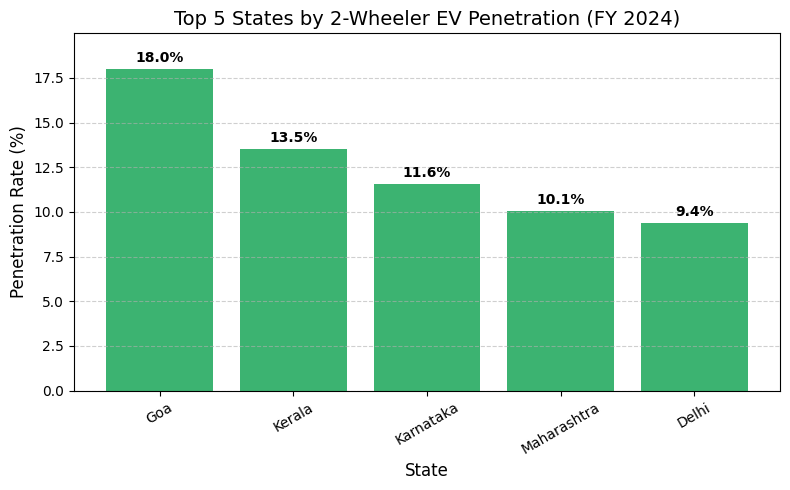

In [20]:

plt.figure(figsize=(8, 5))

bars = plt.bar(df['state'], df['penetration_rate'], color='mediumseagreen')

# Set the y-limit a bit higher to make space for the top label
plt.ylim(0, df['penetration_rate'].max() + 2)  # adds extra space

# Chart title and labels
plt.title('Top 5 States by 2-Wheeler EV Penetration (FY 2024)', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Penetration Rate (%)', fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add percentage labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval:.1f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


- Goa leads the nation in 2-wheeler EV adoption with an impressive 18% penetration rate in FY 2024.
- It is followed by Kerala (13.5%), Karnataka (11.6%), Maharashtra (10.1%), and Delhi (9.4%), indicating strong EV - policy implementation and consumer shift in these states.

### Identify the top 5 states with the highest penetration rate in 4-wheeler EV sales in FY 2024.

In [21]:
query = """
SELECT
    s.state,
    s.vehicle_category AS two_wheelers,
    SUM(s.electric_vehicles_sold)::float / NULLIF(SUM(s.total_vehicles_sold), 0) * 100 AS penetration_rate
FROM 
    electric_vehicle_sales_by_state s
JOIN
    dim_date d ON s.date = d.date
WHERE
    d.fiscal_year = '2024'
    AND s.vehicle_category = '4-Wheelers'
GROUP BY 
    s.state, s.vehicle_category
ORDER BY 
    penetration_rate DESC
LIMIT 5;
"""

df = pd.read_sql(query, conn)
df


,state,two_wheelers,penetration_rate
0,Kerala,4-Wheelers,5.758445
1,Chandigarh,4-Wheelers,4.503112
2,Delhi,4-Wheelers,4.290757
3,Karnataka,4-Wheelers,4.261120
4,Goa,4-Wheelers,4.254353


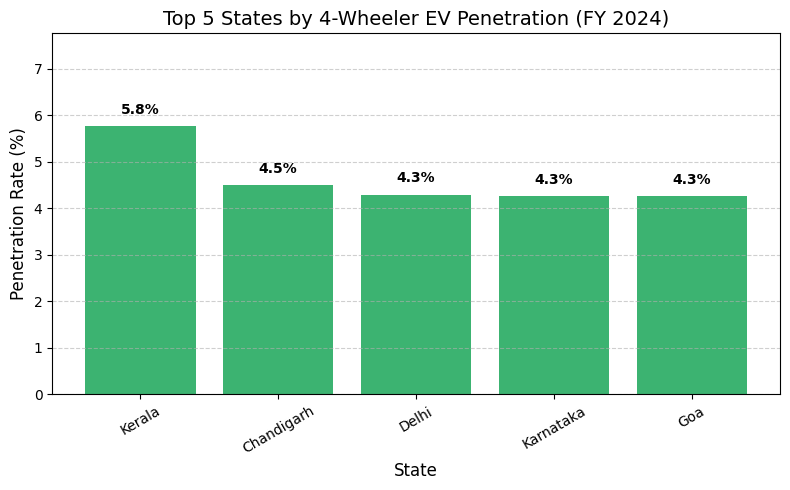

In [22]:

plt.figure(figsize=(8, 5))

bars = plt.bar(df['state'], df['penetration_rate'], color='mediumseagreen')

# Set the y-limit a bit higher to make space for the top label
plt.ylim(0, df['penetration_rate'].max() + 2)  # adds extra space

# Chart title and labels
plt.title('Top 5 States by 4-Wheeler EV Penetration (FY 2024)', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Penetration Rate (%)', fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add percentage labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval:.1f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


- Kerala leads the nation in 4-wheeler EV adoption with an 5.8% penetration rate in FY 2024.
- It is followed by chandigarth (4.5%), Delhi (4.3 %), karnataka (4.3%), and Goa (4.3%),
-  indicating strong EV policy implementation and consumer shift in these states.

##  List the states with negative penetration (decline) in 4-Wheelers EV sales from 2022 to 2024?

In [23]:
query = """ 

WITH penetration_2022 AS (
    SELECT
        s.state,
        ROUND((SUM(s.electric_vehicles_sold)::FLOAT / NULLIF(SUM(s.total_vehicles_sold), 0) * 100)::NUMERIC, 2) AS penetration_2022
    FROM electric_vehicle_sales_by_state s
    JOIN dim_date d ON s.date = d.date
    WHERE d.fiscal_year = '2022'
      AND s.vehicle_category = '4-Wheelers'
    GROUP BY s.state
),

penetration_2024 AS (
    SELECT
        s.state,
        ROUND((SUM(s.electric_vehicles_sold)::FLOAT / NULLIF(SUM(s.total_vehicles_sold), 0) * 100)::NUMERIC, 2) AS penetration_2024
    FROM electric_vehicle_sales_by_state s
    JOIN dim_date d ON s.date = d.date
    WHERE d.fiscal_year = '2024'
      AND s.vehicle_category = '4-Wheelers'
    GROUP BY s.state
)

SELECT 
    p22.state,
    p22.penetration_2022,
    p24.penetration_2024,
    (p24.penetration_2024 - p22.penetration_2022) AS change
FROM penetration_2022 p22
JOIN penetration_2024 p24 ON p22.state = p24.state
WHERE (p24.penetration_2024 - p22.penetration_2022) < 0
ORDER BY change ASC;


"""

df_decline_states = pd.read_sql(query, conn)
df_decline_states


,state,penetration_2022,penetration_2024,change
0,Andaman & Nicobar Island,1.88,0.84,-1.04


- Andaman & Nicobar Islands is the only state where EV adoption for 4-Wheelers actually declined from FY 2022 to FY 2024 

## List the states with negative penetration (decline) in 2-Wheelers EV sales from 2022 to 2024?


In [24]:
query = """ 
WITH penetration_2022 AS (
    SELECT
        s.state,
        ROUND((SUM(s.electric_vehicles_sold)::FLOAT / NULLIF(SUM(s.total_vehicles_sold), 0) * 100)::NUMERIC, 2) AS penetration_2022
    FROM electric_vehicle_sales_by_state s
    JOIN dim_date d ON s.date = d.date
    WHERE d.fiscal_year = '2022'
      AND s.vehicle_category = '2-Wheelers'
    GROUP BY s.state
),

penetration_2024 AS (
    SELECT
        s.state,
        ROUND((SUM(s.electric_vehicles_sold)::FLOAT / NULLIF(SUM(s.total_vehicles_sold), 0) * 100)::NUMERIC, 2) AS penetration_2024
    FROM electric_vehicle_sales_by_state s
    JOIN dim_date d ON s.date = d.date
    WHERE d.fiscal_year = '2024'
      AND s.vehicle_category = '2-Wheelers'
    GROUP BY s.state
)

SELECT 
    p22.state,
    p22.penetration_2022,
    p24.penetration_2024,
    (p24.penetration_2024 - p22.penetration_2022) AS change
FROM penetration_2022 p22
JOIN penetration_2024 p24 ON p22.state = p24.state
WHERE (p24.penetration_2024 - p22.penetration_2022) < 0
ORDER BY change ASC;

"""

decline_2wheeler_df = pd.read_sql(query, conn)
decline_2wheeler_df


,state,penetration_2022,penetration_2024,change
0,Ladakh,4.48,4.06,-0.42


- Ladakh is the only state (in your data) where 2-Wheeler EV penetration decreased from FY 2022 to FY 2024 — a drop of 0.42 percentage points.

## What are the quarterly trends based on sales volume for the top 5 EV makers (4-wheelers) from 2022 to 2024? 

In [25]:
query = """
WITH top_5_makers AS (
    SELECT 
        m.maker
    FROM 
        electric_vehicle_sales_by_makers m
    JOIN 
        dim_date d ON m.date = d.date
    WHERE 
        m.vehicle_category = '4-Wheelers'
        AND d.fiscal_year IN ('2022', '2023', '2024')
    GROUP BY 
        m.maker
    ORDER BY 
        SUM(m.electric_vehicles_sold) DESC
    LIMIT 5
),
quarterly_trends AS (
    SELECT 
        m.maker,
        d.fiscal_year,
        d.quarter,
        SUM(m.electric_vehicles_sold) AS quarterly_ev_sales
    FROM 
        electric_vehicle_sales_by_makers m
    JOIN 
        dim_date d ON m.date = d.date
    WHERE 
        m.vehicle_category = '4-Wheelers'
        AND d.fiscal_year IN ('2022', '2023', '2024')
    GROUP BY 
        m.maker, d.fiscal_year, d.quarter
)

SELECT 
    qt.maker,
    qt.fiscal_year,
    qt.quarter,
    qt.quarterly_ev_sales
FROM 
    quarterly_trends qt
JOIN 
    top_5_makers t5 ON qt.maker = t5.maker
ORDER BY 
    qt.maker, qt.fiscal_year, qt.quarter;
"""

df_quarterly = pd.read_sql(query, conn)
df_quarterly


,maker,fiscal_year,quarter,quarterly_ev_sales
0,BYD India,2022,Q1,0
1,BYD India,2022,Q2,0
2,BYD India,2022,Q3,1
3,BYD India,2022,Q4,32
4,BYD India,2023,Q1,81
5,BYD India,2023,Q2,113
6,BYD India,2023,Q3,103
7,BYD India,2023,Q4,623
8,BYD India,2024,Q1,406
9,BYD India,2024,Q2,310


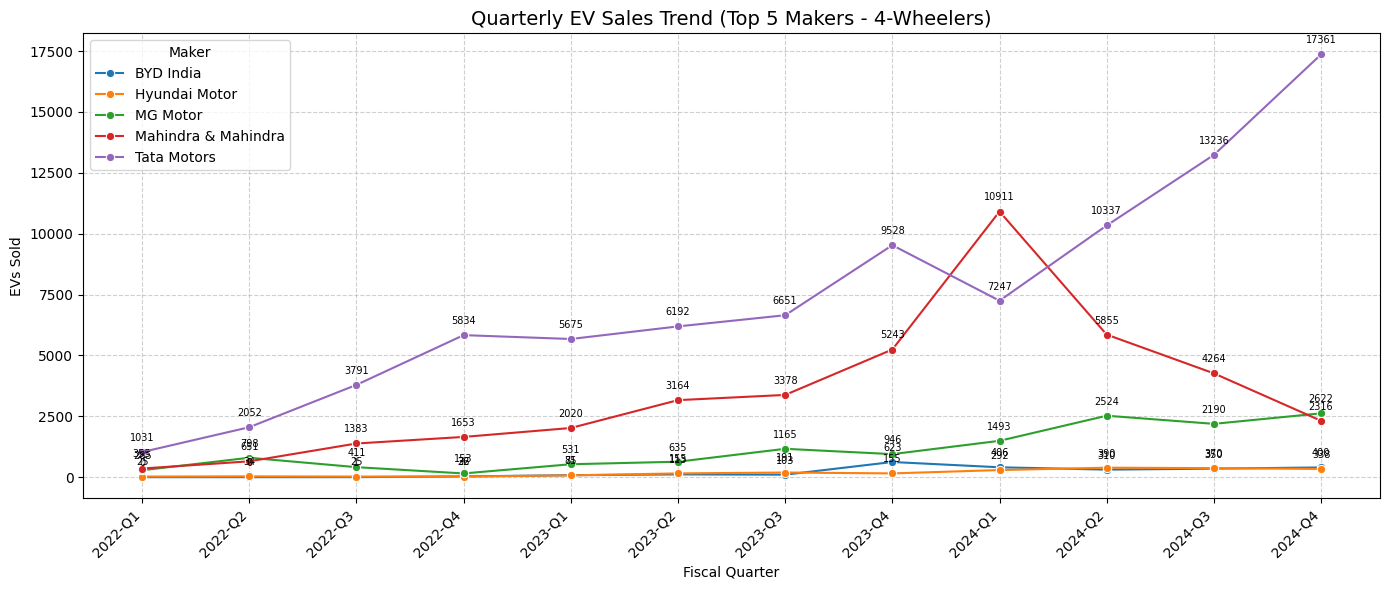

In [26]:


# Prepare period and sort
df_quarterly['period'] = df_quarterly['fiscal_year'] + '-' + df_quarterly['quarter']
df_quarterly.sort_values(by=['maker', 'fiscal_year', 'quarter'], inplace=True)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_quarterly, x='period', y='quarterly_ev_sales', hue='maker', marker='o')

# Add EV sales numbers only (no percentage)
for i, row in df_quarterly.iterrows():
    x = row['period']
    y = row['quarterly_ev_sales']
    label = f"{int(y)}"
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 8), ha='center', fontsize=7)

# Formatting
plt.title('Quarterly EV Sales Trend (Top 5 Makers - 4-Wheelers)', fontsize=14)
plt.xlabel('Fiscal Quarter')
plt.ylabel('EVs Sold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Maker')
plt.show()


- Tata Motors dominates the market with massive growth, followed by Mahindra & Mahindra.

- MG Motor is emerging as a strong third.

- Hyundai and BYD show little momentum — possibly limited models or marketing in India.



## How do the EV sales and penetration rates in Delhi compare to Karnataka for 2024? 

In [27]:

# SQL query
query = """
SELECT 
    s.state,
    s.vehicle_category,
    SUM(s.electric_vehicles_sold) AS total_ev_sales,
    SUM(s.total_vehicles_sold) AS total_vehicle_sales,
    ROUND((SUM(s.electric_vehicles_sold)::FLOAT / NULLIF(SUM(s.total_vehicles_sold), 0) * 100)::NUMERIC, 2) AS penetration_rate
FROM 
    electric_vehicle_sales_by_state s
JOIN 
    dim_date d ON s.date = d.date
WHERE 
    d.fiscal_year = '2024'
    AND s.state IN ('Delhi', 'Karnataka')
GROUP BY 
    s.state, s.vehicle_category
ORDER BY 
    s.state, s.vehicle_category;
"""

# Load into DataFrame
df_comparison = pd.read_sql(query, conn)


# Show result
df_comparison

,state,vehicle_category,total_ev_sales,total_vehicle_sales,penetration_rate
0,Delhi,2-Wheelers,38094,405218,9.40
1,Delhi,4-Wheelers,8630,201130,4.29
2,Karnataka,2-Wheelers,148111,1279767,11.57
3,Karnataka,4-Wheelers,12878,302221,4.26


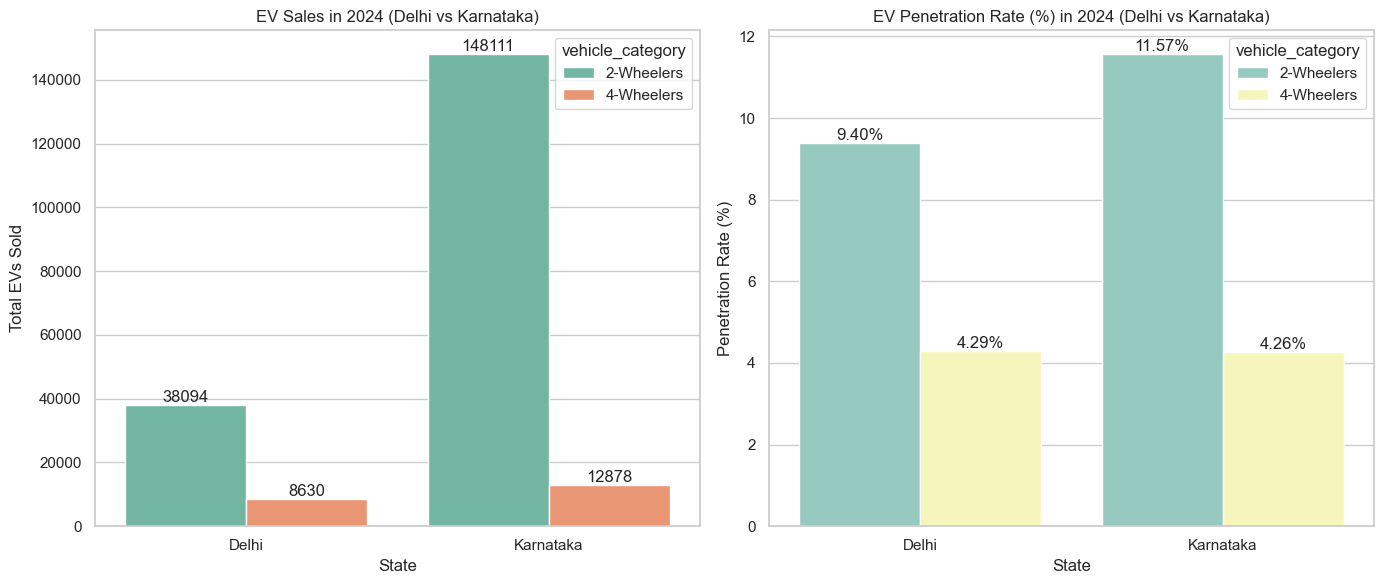

In [28]:
# Set plot style
sns.set(style="whitegrid")

# Create a figure with 2 subplots: Sales and Penetration
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# -------------------- EV Sales Barplot --------------------
sns.barplot(
    data=df_comparison,
    x='state',
    y='total_ev_sales',
    hue='vehicle_category',
    ax=axes[0],
    palette='Set2'
)
axes[0].set_title('EV Sales in 2024 (Delhi vs Karnataka)')
axes[0].set_ylabel('Total EVs Sold')
axes[0].set_xlabel('State')

# Add values on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.0f', label_type='edge')

# -------------------- Penetration Rate Barplot --------------------
sns.barplot(
    data=df_comparison,
    x='state',
    y='penetration_rate',
    hue='vehicle_category',
    ax=axes[1],
    palette='Set3'
)
axes[1].set_title('EV Penetration Rate (%) in 2024 (Delhi vs Karnataka)')
axes[1].set_ylabel('Penetration Rate (%)')
axes[1].set_xlabel('State')

# Add values on bars
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f%%', label_type='edge')

# Adjust layout
plt.tight_layout()
plt.show()

- Karnataka is leading in both sales volume and penetration for 2-wheelers, indicating a more mature or rapidly growing EV ecosystem in this segment.

- Delhi has comparable penetration in 4-wheelers, despite lower total sales—likely due to a smaller base of total vehicle registrations.

- The data suggests that Delhi may benefit from targeted 2-wheeler EV adoption policies to catch up with Karnataka.

## List down the compounded annual growth rate (CAGR) in 4-wheeler units for the top 5 makers from 2022 to 2024. 

In [29]:
query = """
WITH sales_by_year AS (
    SELECT 
        m.maker,
        d.fiscal_year,
        SUM(m.electric_vehicles_sold) AS total_sales
    FROM electric_vehicle_sales_by_makers m
    JOIN dim_date d ON m.date = d.date
    WHERE 
        m.vehicle_category = '4-Wheelers'
        AND d.fiscal_year IN ('2022', '2024')
    GROUP BY m.maker, d.fiscal_year
),
pivoted_sales AS (
    SELECT 
        maker,
        MAX(CASE WHEN fiscal_year = '2022' THEN total_sales END) AS sales_2022,
        MAX(CASE WHEN fiscal_year = '2024' THEN total_sales END) AS sales_2024
    FROM sales_by_year
    GROUP BY maker
),
filtered AS (
    SELECT *
    FROM pivoted_sales
    WHERE sales_2022 > 0
),
top_5 AS (
    SELECT *
    FROM filtered
    ORDER BY sales_2024 DESC
    LIMIT 5
)
SELECT 
    maker,
    sales_2022,
    sales_2024,
    ROUND((POWER(sales_2024::NUMERIC / sales_2022, 1.0 / 2) - 1) * 100, 2) AS cagr_percentage
FROM top_5
ORDER BY cagr_percentage DESC;

"""

df_cagr = pd.read_sql(query, conn)
df_cagr


,maker,sales_2022,sales_2024,cagr_percentage
0,BYD India,33,1466,566.52
1,Hyundai Motor,110,1390,255.48
2,Mahindra & Mahindra,4042,23346,140.33
3,MG Motor,1647,8829,131.53
4,Tata Motors,12708,48181,94.71


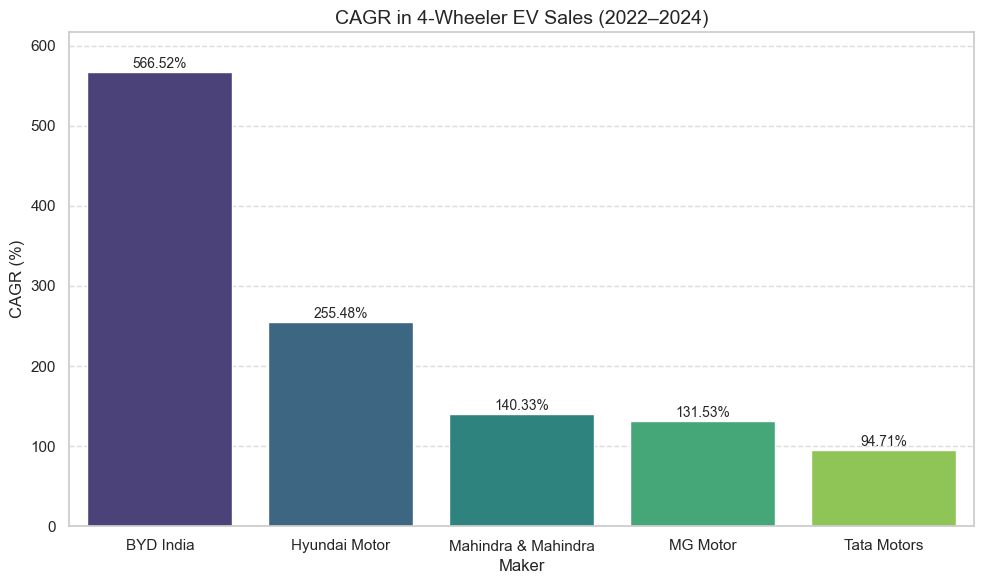

In [30]:
# Sort the DataFrame by CAGR for better visualization (optional)
df_cagr.sort_values(by='cagr_percentage', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_cagr,
    x='maker',
    y='cagr_percentage',
    hue='maker',
    palette='viridis',
    legend=False  # Hide the redundant legend
)

# Add value labels on top of bars
for index, row in df_cagr.iterrows():
    plt.text(x=index, y=row['cagr_percentage'] + 5, 
             s=f"{row['cagr_percentage']}%", 
             ha='center', fontsize=10)

plt.title('CAGR in 4-Wheeler EV Sales (2022–2024)', fontsize=14)
plt.xlabel('Maker')
plt.ylabel('CAGR (%)')
plt.ylim(0, df_cagr['cagr_percentage'].max() + 50)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


- BYD India leads in CAGR due to low initial sales base, showing rapid growth.
- Tata Motors while having the largest sales volume, has a lower CAGR due to an already strong base.
- Other top makers like Hyundai, Mahindra, and MG Motor show consistent expansion from 2022 to 2024.

##  List down the top 10 states that had the highest compounded annual growth rate (CAGR) from 2022 to 2024 in total 4- wheel vehicles sold.

In [31]:
# 1. Define the query for 4-Wheelers only
query = """
WITH yearly_sales AS (
    SELECT 
        s.state,
        d.fiscal_year,
        SUM(s.total_vehicles_sold) AS total_sales
    FROM electric_vehicle_sales_by_state s
    JOIN dim_date d ON s.date = d.date
    WHERE 
        d.fiscal_year IN ('2022', '2024')
        AND s.vehicle_category = '4-Wheelers'
    GROUP BY s.state, d.fiscal_year
),
pivoted AS (
    SELECT 
        state,
        MAX(CASE WHEN fiscal_year = '2022' THEN total_sales END) AS sales_2022,
        MAX(CASE WHEN fiscal_year = '2024' THEN total_sales END) AS sales_2024
    FROM yearly_sales
    GROUP BY state
),
filtered AS (
    SELECT *
    FROM pivoted
    WHERE sales_2022 > 0
)
SELECT 
    state,
    sales_2022,
    sales_2024,
    ROUND((POWER(sales_2024::NUMERIC / sales_2022, 1.0 / 2) - 1) * 100, 2) AS cagr_percentage
FROM filtered
ORDER BY cagr_percentage DESC
LIMIT 10;
"""

# 2. Run query and load result into DataFrame
df_cagr_4w_states = pd.read_sql(query, conn)

# 3. Display result
df_cagr_4w_states


,state,sales_2022,sales_2024,cagr_percentage
0,Goa,13865,24234,32.21
1,Arunachal Pradesh,7688,13219,31.13
2,Mizoram,3371,5387,26.41
3,Puducherry,7508,11573,24.15
4,Haryana,174990,269304,24.06
5,Meghalaya,9254,14146,23.64
6,Andaman & Nicobar Island,1169,1777,23.29
7,Delhi,135345,201130,21.90
8,Karnataka,204252,302221,21.64
9,DNH and DD,3725,5507,21.59


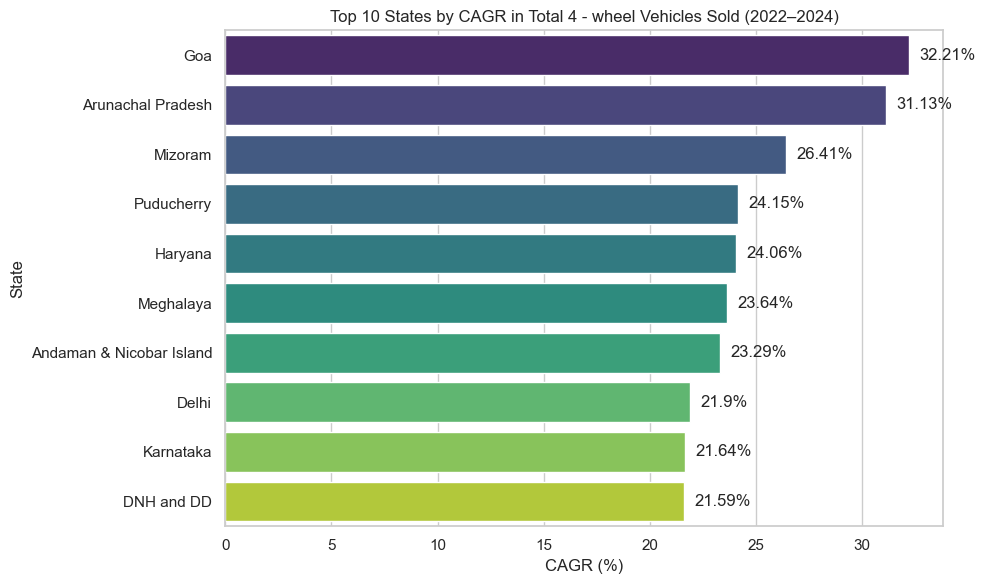

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_cagr_4w_states,
    y='state',
    x='cagr_percentage',
    hue='state',        # Set hue to y-axis variable
    palette='viridis',  # Use palette
    dodge=False,        # Ensures bars don't split
    legend=False        # Hides the legend
)

# Add labels
for i, row in df_cagr_4w_states.iterrows():
    plt.text(row['cagr_percentage'] + 0.5, i, f"{row['cagr_percentage']}%", va='center')

plt.title('Top 10 States by CAGR in Total 4 - wheel Vehicles Sold (2022–2024)')
plt.xlabel('CAGR (%)')
plt.ylabel('State')
plt.tight_layout()
plt.show()

- Goa and Arunachal Pradesh lead the country in 4-wheeler sales growth, with CAGR of 32.21% and 31.13% respectively.

- Smaller regions like Mizoram and Puducherry also show strong adoption trends, surpassing larger markets.- 

- Delhi and Karnataka, while major markets, show relatively moderate growth (~21–22%), likely due to their already high base volumes.

- The consistent growth across smaller states and UTs suggests emerging markets are rapidly embracing 4-wheeler EVs.

## List down the top 10 states that had the highest compounded annual growth rate (CAGR) from 2022 to 2024 in total 2 - wheel vehicles sold.

In [33]:
# 1. Define the query for 2-Wheelers only
query = """
WITH yearly_sales AS (
    SELECT 
        s.state,
        d.fiscal_year,
        SUM(s.total_vehicles_sold) AS total_sales
    FROM electric_vehicle_sales_by_state s
    JOIN dim_date d ON s.date = d.date
    WHERE 
        d.fiscal_year IN ('2022', '2024')
        AND s.vehicle_category = '2-Wheelers'
    GROUP BY s.state, d.fiscal_year
),
pivoted AS (
    SELECT 
        state,
        MAX(CASE WHEN fiscal_year = '2022' THEN total_sales END) AS sales_2022,
        MAX(CASE WHEN fiscal_year = '2024' THEN total_sales END) AS sales_2024
    FROM yearly_sales
    GROUP BY state
),
filtered AS (
    SELECT *
    FROM pivoted
    WHERE sales_2022 > 0
)
SELECT 
    state,
    sales_2022,
    sales_2024,
    ROUND((POWER(sales_2024::NUMERIC / sales_2022, 1.0 / 2) - 1) * 100, 2) AS cagr_percentage
FROM filtered
ORDER BY cagr_percentage DESC
LIMIT 10;
"""

# 2. Run query and load result into DataFrame
df_cagr_2w_states = pd.read_sql(query, conn)

# 3. Display result
df_cagr_2w_states


,state,sales_2022,sales_2024,cagr_percentage
0,Ladakh,268,763,68.73
1,Meghalaya,12939,22482,31.82
2,Karnataka,803642,1279767,26.19
3,Goa,34507,54290,25.43
4,Delhi,266195,405218,23.38
5,Rajasthan,734752,1094945,22.07
6,Gujarat,831276,1236242,21.95
7,Assam,311051,456726,21.17
8,Maharashtra,1311960,1817343,17.70
9,Chandigarh,16238,22496,17.70


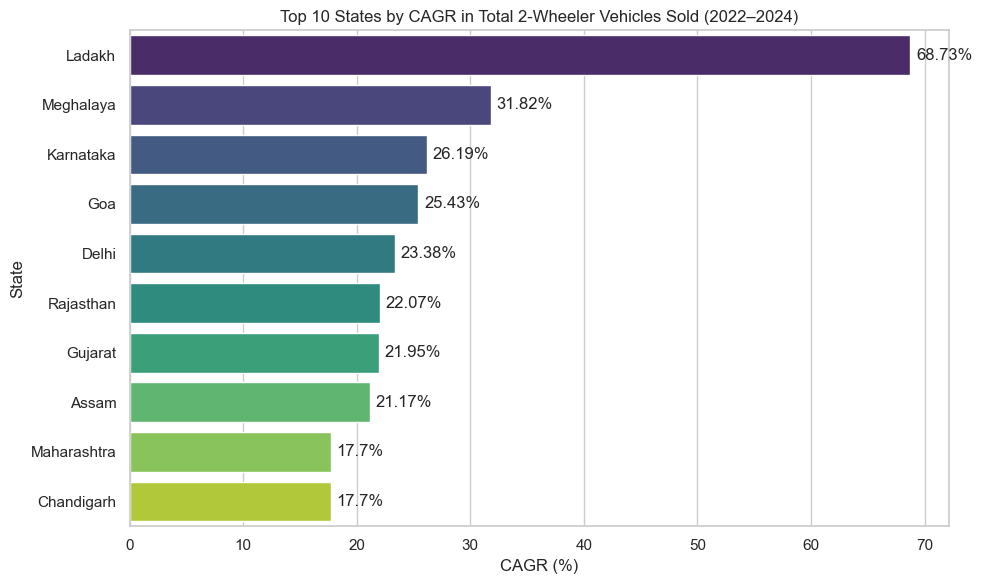

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_cagr_2w_states,
    y='state',
    x='cagr_percentage',
    hue='state',
    palette='viridis',
    dodge=False,
    legend=False
)

# Add labels to bars
for i, row in df_cagr_2w_states.iterrows():
    plt.text(row['cagr_percentage'] + 0.5, i, f"{row['cagr_percentage']}%", va='center')

plt.title('Top 10 States by CAGR in Total 2-Wheeler Vehicles Sold (2022–2024)')
plt.xlabel('CAGR (%)')
plt.ylabel('State')
plt.tight_layout()
plt.show()


- Ladakh tops the chart with an impressive CAGR of 68.73%, indicating rapid EV adoption from a low base.

- Meghalaya and Karnataka follow with strong growth at 31.82% and 26.19%, showing both emerging and established markets expanding.

- High population states like Delhi, Rajasthan, and Maharashtra show steady growth (~17–23%), reflecting ongoing transition momentum.

- Goa and Chandigarh also demonstrate significant uptick in 2-wheeler EV sales despite their smaller geographic footprint.

- The overall trend shows that both smaller and larger states are increasingly embracing electric mobility.



## What are the peak and low season months for 2 wheel EV sales based on the data from 2022 to 2024?

In [35]:
query = """
SELECT 
    EXTRACT(MONTH FROM s.date) AS month,
    SUM(s.electric_vehicles_sold) AS total_2w_sales
FROM 
    electric_vehicle_sales_by_state s
JOIN 
    dim_date d ON s.date = d.date
WHERE 
    d.fiscal_year IN ('2022', '2023', '2024')  AND s.vehicle_category = '2-Wheelers'
GROUP BY 
    month
ORDER BY 
    month;
"""

df_monthly_2w_sales_total = pd.read_sql(query, conn)
df_monthly_2w_sales_total 

,month,total_2w_sales
0,1.0,176143
1,2.0,183756
2,3.0,270309
3,4.0,125778
4,5.0,149013
5,6.0,94891
6,7.0,115472
7,8.0,130747
8,9.0,135060
9,10.0,172686


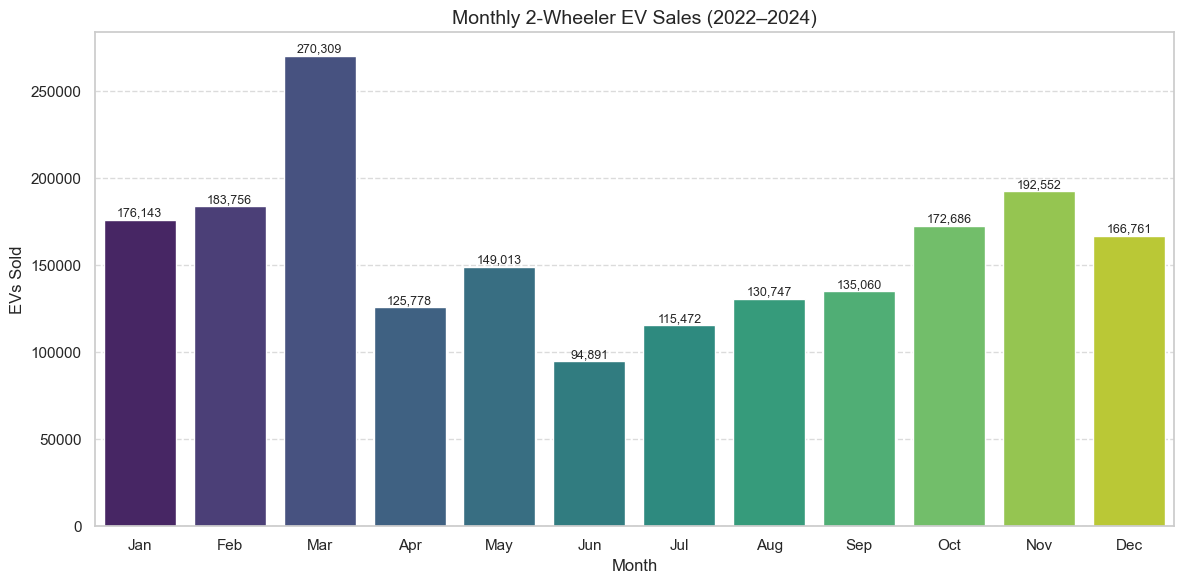

In [36]:
# Ensure month names are created
df_monthly_2w_sales_total['month_name'] = df_monthly_2w_sales_total['month'].apply(lambda x: calendar.month_abbr[int(x)])

# Sort months to display Jan to Dec in order
month_order = list(calendar.month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']
df_monthly_2w_sales_total['month_name'] = pd.Categorical(df_monthly_2w_sales_total['month_name'], categories=month_order, ordered=True)
df_monthly_2w_sales_total.sort_values('month_name', inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_monthly_2w_sales_total,
    x='month_name',
    y='total_2w_sales',
    hue='month_name',
    palette='viridis',
    legend=False
)

# Add value labels
for i, row in df_monthly_2w_sales_total.iterrows():
    plt.text(
        x=i,
        y=row['total_2w_sales'] + 2000,  # small gap above bar
        s=f"{row['total_2w_sales']:,}",  # comma format for readability
        ha='center',
        fontsize=9
    )

# Styling
plt.title('Monthly 2-Wheeler EV Sales (2022–2024)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('EVs Sold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

📈 Peak Season Months
March had the highest 2-wheeler EV sales across all months, reaching 270,309 units.

This is likely due to year-end incentives, tax benefits, or government scheme deadlines.

November and February also performed well with 192,552 and 183,756 sales respectively, suggesting strong demand during the festive and financial quarters.

📉 Low Season Months
June recorded the lowest sales with only 94,891 units sold.

This drop may correlate with monsoon onset, agricultural season focus, or lower purchasing activity.

July and April were also relatively low-performing months, indicating a post-year-end dip.

🔄 General Trend
Sales rise significantly in Q1 (Jan–Mar), dip in mid-year (Apr–Jul), and then pick up again toward Q4 (Oct–Dec).

The pattern shows a cyclical sales trend, likely influenced by financial year planning, festivals, and policy deadlines.

## What are the peak and low season months for 4 wheel EV sales based on the data from 2022 to 2024?

In [37]:
query = """
SELECT 
    EXTRACT(MONTH FROM s.date) AS month,
    SUM(s.electric_vehicles_sold) AS total_4w_sales
FROM 
    electric_vehicle_sales_by_state s
JOIN 
    dim_date d ON s.date = d.date
WHERE 
    d.fiscal_year IN ('2022', '2023', '2024')  AND s.vehicle_category = '4-Wheelers'
GROUP BY 
    month
ORDER BY 
    month;
"""

df_monthly_4w_sales_total = pd.read_sql(query, conn)
df_monthly_4w_sales_total 

,month,total_4w_sales
0,1.0,12956
1,2.0,14293
2,3.0,21278
3,4.0,8879
4,5.0,10856
5,6.0,11818
6,7.0,11954
7,8.0,11214
8,9.0,10912
9,10.0,12499


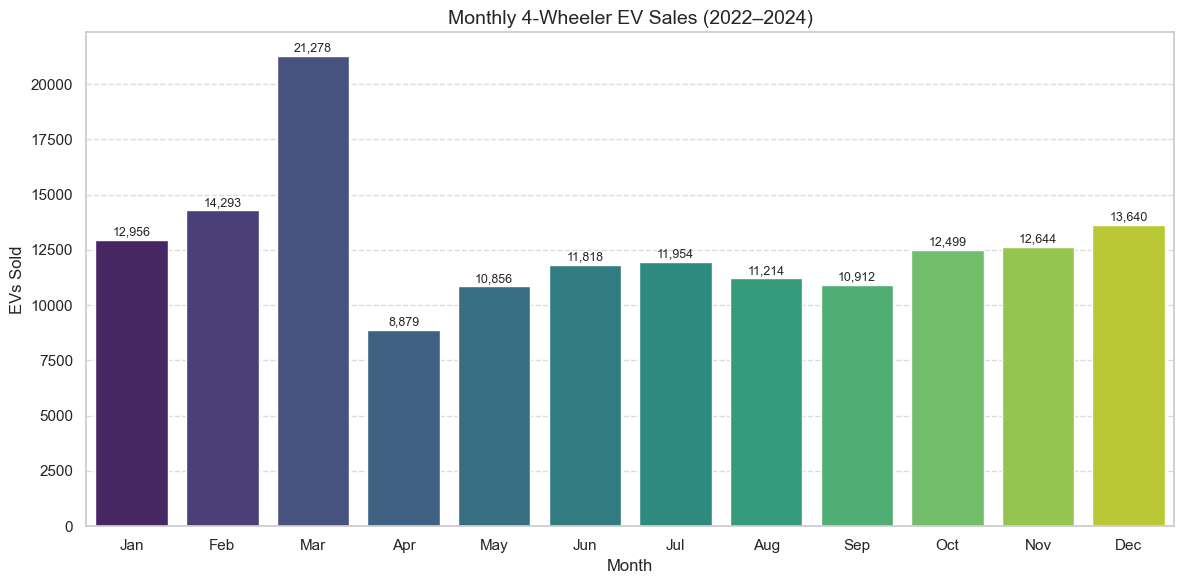

In [38]:
# Add month names
df_monthly_4w_sales_total['month_name'] = df_monthly_4w_sales_total['month'].apply(lambda x: calendar.month_abbr[int(x)])

# Ensure correct order
month_order = list(calendar.month_abbr)[1:]
df_monthly_4w_sales_total['month_name'] = pd.Categorical(df_monthly_4w_sales_total['month_name'], categories=month_order, ordered=True)
df_monthly_4w_sales_total.sort_values('month_name', inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_monthly_4w_sales_total,
    x='month_name',
    y='total_4w_sales',
    hue='month_name',
    palette='viridis',
    legend=False
)

# Add value labels
for i, row in df_monthly_4w_sales_total.iterrows():
    plt.text(
        x=i,
        y=row['total_4w_sales'] + 200, 
        s=f"{int(row['total_4w_sales']):,}", 
        ha='center',
        fontsize=9
    )

plt.title('Monthly 4-Wheeler EV Sales (2022–2024)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('EVs Sold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

March is the peak month

With 21,278 units sold, March sees the highest EV sales, likely driven by financial year-end incentives, tax planning, or dealership targets.

April marks the lowest sales

Only 8,879 units were sold in April, a sharp dip following March. This may be due to consumer fatigue, budget resets, or the start of the new fiscal year.

Q1 (Jan–Mar) is the strongest quarter

Totaling over 48,000 units, Q1 dominates in volume — ideal for promotional or policy interventions.

Steady mid-year performance (May–Sep)

Sales remain relatively stable between 10,000–12,000 units, indicating a consistent base demand during these months.

Gradual rise towards year-end (Oct–Dec)

October to December sees a recovery and steady growth, with December hitting 13,640 units, possibly due to festival season purchases and year-end deals.

##  What is the projected number of EV sales (including 2-wheelers and 4wheelers) for the top 10 states by penetration rate in 2030, based on the compounded annual growth rate (CAGR) from previous years?

In [39]:
query = """
WITH total_sales AS (
    SELECT 
        s.state,
        d.fiscal_year,
        SUM(s.total_vehicles_sold) AS total_sales
    FROM electric_vehicle_sales_by_state s
    JOIN dim_date d ON s.date = d.date
    WHERE d.fiscal_year IN ('2022', '2024')
    GROUP BY s.state, d.fiscal_year
),

pivoted AS (
    SELECT 
        state,
        MAX(CASE WHEN fiscal_year = '2022' THEN total_sales END) AS sales_2022,
        MAX(CASE WHEN fiscal_year = '2024' THEN total_sales END) AS sales_2024
    FROM total_sales
    GROUP BY state
),

filtered AS (
    SELECT *
    FROM pivoted
    WHERE sales_2022 > 0
),

cagr_calc AS (
    SELECT 
        state,
        sales_2022,
        sales_2024,
        ROUND((POWER(sales_2024::NUMERIC / sales_2022, 1.0 / 2) - 1), 6) AS cagr_decimal  -- Decimal format
    FROM filtered
),

projected AS (
    SELECT 
        state,
        sales_2024,
        ROUND(cagr_decimal * 100, 2) AS cagr_percentage,
        ROUND(sales_2024 * POWER(1 + cagr_decimal, 6))::BIGINT AS projected_2030_sales
    FROM cagr_calc
)

-- You can replace this filter with actual top 10 states by penetration if you have that data
SELECT * 
FROM projected
ORDER BY projected_2030_sales DESC
LIMIT 10;
"""

df_projection = pd.read_sql(query, conn)

# Display
df_projection


,state,sales_2024,cagr_percentage,projected_2030_sales
0,Karnataka,1581988,25.28,6117423
1,Maharashtra,2293994,17.31,5978060
2,Gujarat,1590987,20.55,4881766
3,Uttar Pradesh,2932347,8.36,4747400
4,Rajasthan,1300476,21.50,4183158
5,Tamil Nadu,1716940,12.98,3571380
6,Madhya Pradesh,1286182,15.32,3024750
7,Bihar,1132703,12.63,2312576
8,Delhi,606348,22.88,2087855
9,Haryana,732029,17.68,1944254


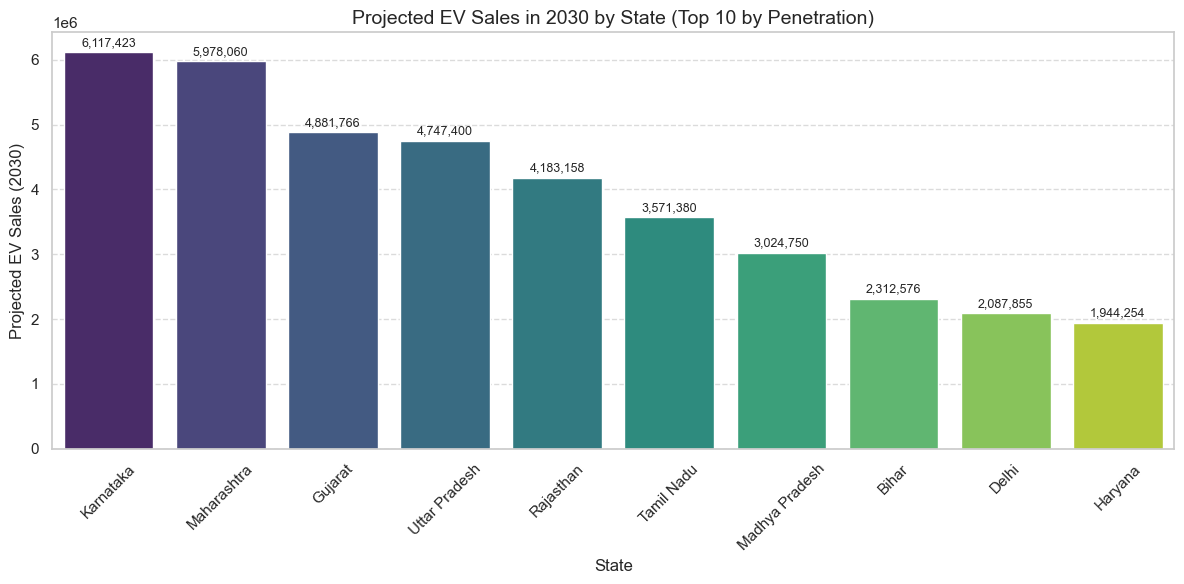

In [40]:
# Sort by projected sales for better visual order
df_projection_sorted = df_projection.sort_values('projected_2030_sales', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_projection_sorted, x='state', y='projected_2030_sales',
            hue='state', palette='viridis', legend=False)

# Add labels above bars
for index, row in enumerate(df_projection_sorted.itertuples()):
    plt.text(index, row.projected_2030_sales + 100000,
             f"{row.projected_2030_sales:,}", ha='center', fontsize=9)

# Chart styling
plt.title("Projected EV Sales in 2030 by State (Top 10 by Penetration)", fontsize=14)
plt.ylabel("Projected EV Sales (2030)")
plt.xlabel("State")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

 1. Karnataka and Maharashtra lead the EV adoption race
Karnataka is projected to sell over 6.1 million EVs by 2030 — the highest among all states.

Maharashtra follows closely with nearly 6 million projected sales.

Both have strong base numbers in 2024 and solid CAGR (25.28% and 17.31%).

🔹 2. High CAGR amplifies future volume
Delhi, despite having a lower 2024 base (606k), is projected to cross 2 million sales in 2030 due to its high 22.88% CAGR.

This shows how smaller bases + high CAGR can still lead to aggressive growth.

🔹 3. Uttar Pradesh has a large base but lower CAGR
Uttar Pradesh had the highest 2024 sales (2.9M), but due to a modest 8.36% CAGR, it is projected at ~4.7M in 2030 — ranking behind states with smaller 2024 sales but higher CAGR (like Gujarat, Rajasthan).

🔹 4. States like Bihar and Madhya Pradesh show potential
Both have CAGR in the 12–15% range, pushing their projections to 2.3M+ and 3M+, respectively.



## Estimate the revenue growth rate of 4-wheeler and 2-wheelers EVs in India for 2022 vs 2024 and 2023 vs 2024, assuming an average unit price. H 

| Vehicle Category | Average Price (INR) |
| ---------------- | ------------------- |
| 2-Wheelers       | ₹85,000             |
| 4-Wheelers       | ₹15,00,000          |


In [41]:

query = """
WITH sales_summary AS (
    SELECT 
        d.fiscal_year,
        s.vehicle_category,
        SUM(s.total_vehicles_sold) AS total_units
    FROM electric_vehicle_sales_by_state s
    JOIN dim_date d ON s.date = d.date
    WHERE 
        d.fiscal_year IN ('2022', '2023', '2024')
        AND s.vehicle_category IN ('2-Wheelers', '4-Wheelers')
    GROUP BY d.fiscal_year, s.vehicle_category
),
price_map AS (
    SELECT '2-Wheelers' AS vehicle_category, 85000::NUMERIC AS avg_price
    UNION
    SELECT '4-Wheelers', 1500000
),
revenue_calc AS (
    SELECT 
        s.fiscal_year,
        s.vehicle_category,
        s.total_units,
        p.avg_price,
        s.total_units * p.avg_price AS revenue
    FROM sales_summary s
    JOIN price_map p ON s.vehicle_category = p.vehicle_category
),
pivoted AS (
    SELECT 
        vehicle_category,
        MAX(CASE WHEN fiscal_year = '2022' THEN revenue END) AS rev_2022,
        MAX(CASE WHEN fiscal_year = '2023' THEN revenue END) AS rev_2023,
        MAX(CASE WHEN fiscal_year = '2024' THEN revenue END) AS rev_2024
    FROM revenue_calc
    GROUP BY vehicle_category
)
SELECT 
    vehicle_category,
    rev_2022,
    rev_2023,
    rev_2024,
    ROUND(((rev_2024 - rev_2022) / NULLIF(rev_2022, 0)) * 100, 2) AS growth_2022_vs_2024,
    ROUND(((rev_2024 - rev_2023) / NULLIF(rev_2023, 0)) * 100, 2) AS growth_2023_vs_2024
FROM pivoted;

"""

df_revenue_growth = pd.read_sql(query, conn)
df_revenue_growth

,vehicle_category,rev_2022,rev_2023,rev_2024,growth_2022_vs_2024,growth_2023_vs_2024
0,2-Wheelers,1.147727e+12,1.361809e+12,1.478560e+12,28.83,8.57
1,4-Wheelers,4.378738e+12,5.399842e+12,5.673645e+12,29.57,5.07


In [ ]:

# Reshape the data
df_melted = df_revenue_growth.melt(
    id_vars='vehicle_category',
    value_vars=['rev_2022', 'rev_2023', 'rev_2024'],
    var_name='Year',
    value_name='Revenue'
)

# Clean year labels
df_melted['Year'] = df_melted['Year'].str.extract(r'(\d{4})')

# Convert revenue to ₹ Crores
df_melted['Revenue'] = df_melted['Revenue'] / 1e7

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_melted,
    x='Year',
    y='Revenue',
    hue='vehicle_category',
    palette='viridis'
)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9, padding=2)

# Styling
plt.title('EV Revenue by Vehicle Category (2022–2024)', fontsize=14)
plt.ylabel('Revenue (₹ Crores)')
plt.xlabel('Year')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


🚗 4-Wheelers Dominate Revenue Share
In all three years (2022 to 2024), 4-wheeler EVs generate significantly more revenue than 2-wheelers.

This is expected due to the much higher average unit price (₹15,00,000 vs ₹85,000).

📈 Consistent Revenue Growth
2-Wheelers grew from ₹1.15 lakh Cr in 2022 → ₹1.48 lakh Cr in 2024 (~29% increase).

4-Wheelers grew from ₹4.38 lakh Cr in 2022 → ₹5.67 lakh Cr in 2024 (~30% increase).

This indicates strong, steady growth in both segments, with 4-wheelers showing slightly higher absolute revenue gain.